# Knot Lensing

## Lensing a Gaussian and comparing by eye to the observed knot

### RELICS WHL0137-08 long z ~ 6 arc

Brian Welch & Dan Coe

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
# https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('/Users/dcoe/p/matplotlibrc.txt')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#check what you actually use, delete unused imports
import numpy as np
import os
from astropy.io import fits
#from astropy.modeling.functional_models import Sersic2D
from astropy.convolution import convolve, convolve_fft
from astropy.modeling.models import Gaussian2D
#from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import ImageNormalize, LinearStretch, SqrtStretch, LogStretch, PowerStretch, ManualInterval
#from astropy.visualization.mpl_normalize import ImageNormalize
#import math
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
deflx = fits.open('dx_z6_2HST.fits')[1].data
defly = fits.open('dy_z6_2HST.fits')[1].data

In [4]:
deflx /= .06 # arcsec -> pixels
defly /= .06 # arcsec -> pixels

In [5]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def Dds_Ds(zl, zs):
    Dds = cosmo.angular_diameter_distance_z1z2(zl, zs)
    Ds  = cosmo.angular_diameter_distance_z1z2(0 , zs)
    return (Dds / Ds).value

In [6]:
# Rescale deflections from z=6 to z=6.2
zl = 0.566
zs_in  = 6
zs_out = 6.2
Dds_Ds_in  = Dds_Ds(zl, zs_in)
Dds_Ds_out = Dds_Ds(zl, zs_out)
deflx *= Dds_Ds_out / Dds_Ds_in
defly *= Dds_Ds_out / Dds_Ds_in

In [7]:
# Load HST image
imdir = '../images'
imfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_drz_sci.fits'
imfile = os.path.join(imdir, imfile)
data = fits.open(imfile)[0].data

In [8]:
xlo, xhi = 2780, 3030
ylo, yhi = 1860, 2070
data_crop = data[ylo:yhi,xlo:xhi]

In [9]:
# Extract star for convolution
starx, stary = 2232-1, 1622-1
d = 7
star = data[stary-d:stary+d+1, starx-d:starx+d+1]
star.shape  # make sure # of pixels on each side are odd

(15, 15)

In [10]:
# Image plane grid
yy, xx = np.indices(deflx.shape)

# Source position grid for z=zs
xss = xx - deflx
yss = yy - defly

In [11]:
x1, y1 = (2950, 1976) # lower knot
x1, y1 = (2981, 2006) # upper knot

# Delens input back to source plane
xs1 = x1 - deflx[y1-1, x1-1]
ys1 = y1 - defly[y1-1, x1-1]

In [12]:
# Create Gaussian source to be relensed
amplitude = 1
sigma = 3

gauss = Gaussian2D(amplitude, xs1, ys1, sigma, sigma)
xss_crop = xss[ylo:yhi,xlo:xhi]
yss_crop = yss[ylo:yhi,xlo:xhi]
gss_crop = gauss(xss_crop, yss_crop)

gss_convolved = convolve_fft(gss_crop, star)

<IPython.core.display.Javascript object>


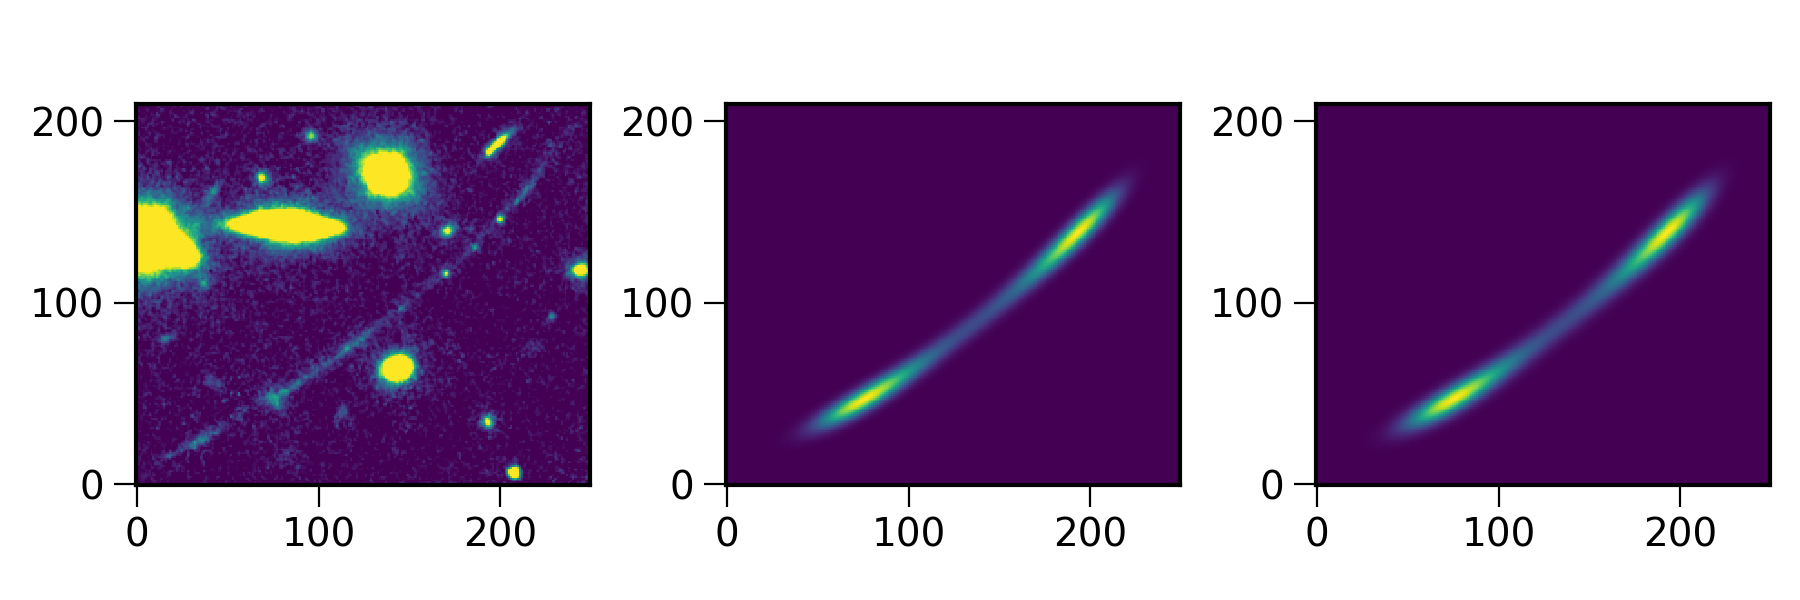

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(data_crop, vmin=-0.001, vmax=0.08)
ax[1].imshow(gss_crop)
ax[2].imshow(gss_convolved)

In [14]:
extent = xlo, xhi, ylo, yhi

norm = ImageNormalize(stretch=LinearStretch(), vmin=-0.001, vmax=0.08)
#norm = ImageNormalize(stretch=LogStretch())

<IPython.core.display.Javascript object>


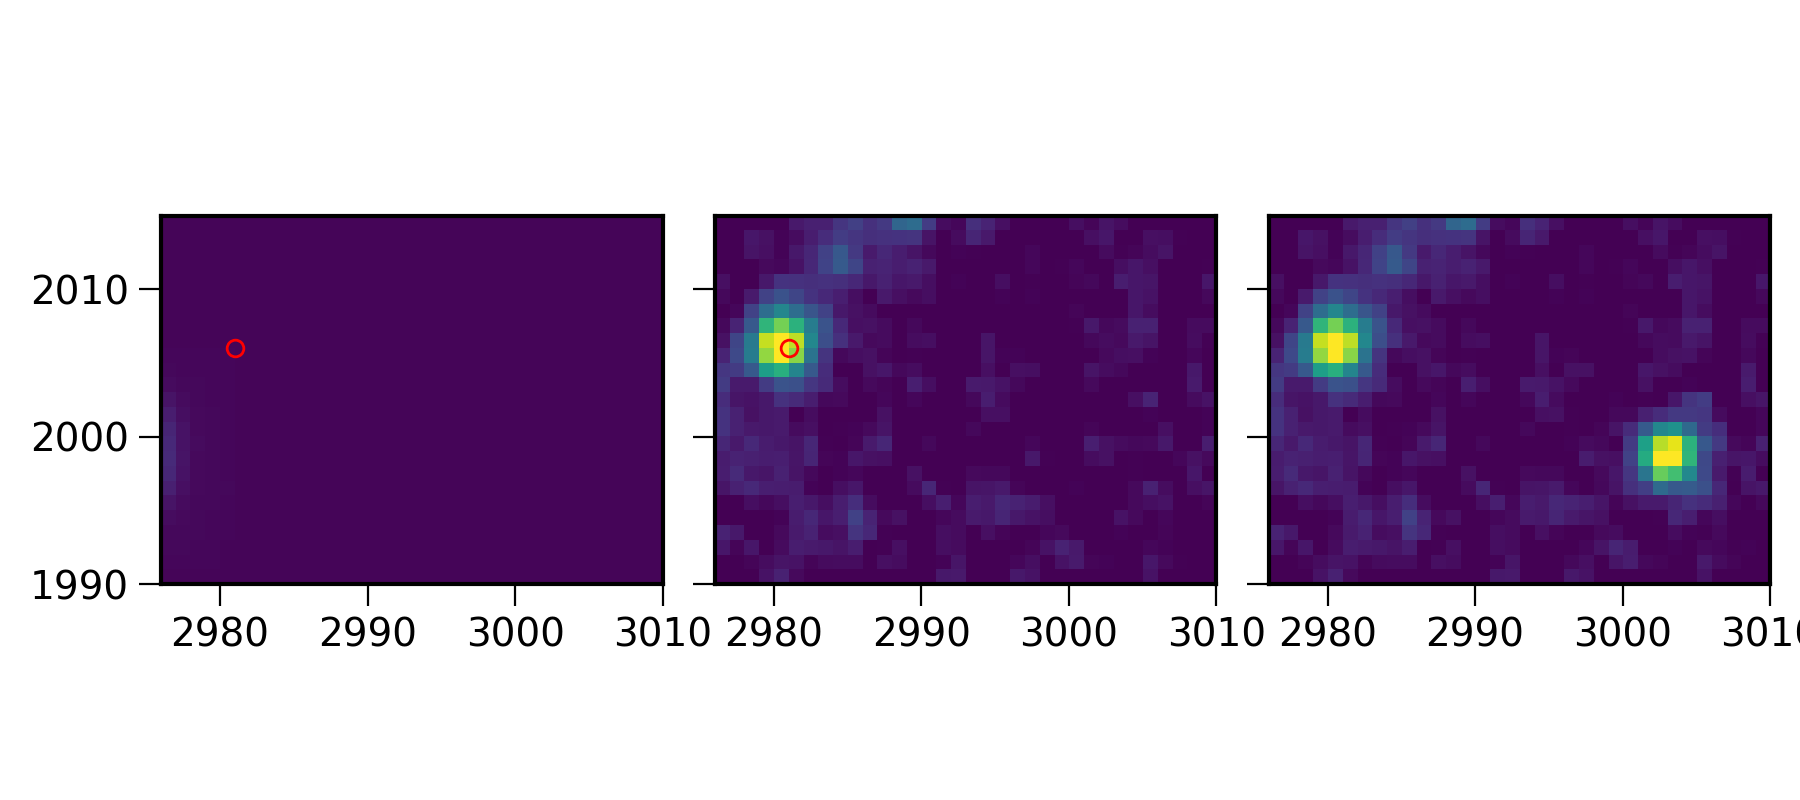

(1990, 2015)

In [15]:
sigma = 0.1
amplitude = 0.125 / sigma

gauss = Gaussian2D(amplitude, xs1, ys1, sigma, sigma)
gss_crop = gauss(xss_crop, yss_crop)
gss_convolved = convolve_fft(gss_crop, star)

offset = 30
data_sim = data_crop + 0
data_sim[:,offset:] += gss_convolved[:,:-offset]

fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)

ax[0].imshow(gss_convolved, extent=extent, norm=norm)
ax[0].plot(x1, y1, 'o', mfc='None', mec='r')

ax[1].imshow(data_crop, extent=extent, norm=norm)
ax[1].plot(x1, y1, 'o', mfc='None', mec='r')

ax[2].imshow(data_sim, extent=extent, norm=norm)
#ax[2].plot(x1, y1, 'o', mfc='None', mec='r')

plt.xlim(2976, 3010)
plt.ylim(1990, 2015)

In [16]:
sigma  # pixels

0.1

In [17]:
radius = sigma * 0.06 * u.arcsec  # pixels -> arcsec
radius

<Quantity 0.006 arcsec>

In [18]:
1 / cosmo.arcsec_per_kpc_proper(zs_out)

<Quantity 5.60856953 kpc / arcsec>

In [19]:
radius = radius / cosmo.arcsec_per_kpc_proper(zs_out)
radius.to(u.pc)

<Quantity 33.65141719 pc>